In [1]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot,dates

import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
weather_train=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/weather_train.csv')
train=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/train.csv')

building_meta = pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/building_metadata.csv')
weather_test=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/weather_test.csv')
test=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/test.csv')

In [3]:
print('Shape of Weather Train',weather_train.shape)
print('Shape of Weather Test',weather_test.shape)

Shape of Weather Train (139773, 9)
Shape of Weather Test (277243, 9)


In [4]:
print('Size of train data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of building_meta data', building_meta.shape)
print('Size of test data', test.shape)
print('Size of weather_test data', weather_test.shape)

Size of train data (20216100, 4)
Size of weather_train data (139773, 9)
Size of building_meta data (1449, 6)
Size of test data (41697600, 4)
Size of weather_test data (277243, 9)


In [5]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [6]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [7]:
print('Number of Unique Buildings TRAIN',len(train.building_id.unique()))
print('Range of TimeStamp TRAIN',np.min(train['timestamp']),'-',np.max(train['timestamp']))
print('Number of Unique Buildings',len(test.building_id.unique()))
print('Range of TimeStamp',np.min(test['timestamp']),'-',np.max(test['timestamp']))

Number of Unique Buildings TRAIN 1449
Range of TimeStamp TRAIN 2016-01-01 00:00:00 - 2016-12-31 23:00:00
Number of Unique Buildings 1449
Range of TimeStamp 2017-01-01 00:00:00 - 2018-12-31 23:00:00


In [8]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train=reduce_mem_usage(train, verbose=True)
weather_train=reduce_mem_usage(weather_train, verbose=True)
building_meta=reduce_mem_usage(building_meta, verbose=True)
test=reduce_mem_usage(test, verbose=True)
weather_test=reduce_mem_usage(weather_test, verbose=True)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [10]:
%%time
print('*********Combining train data*********')
train = train.merge(building_meta, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how="left")
print('train shape',train.shape)
del weather_train

print('*********Combining test data*********')
test = test.merge(building_meta, left_on = "building_id", right_on = "building_id", how = "left")
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how="left")
print('test shape',test.shape)
del weather_test

*********Combining train data*********
train shape (20216100, 16)
*********Combining test data*********
test shape (41697600, 16)
Wall time: 28.7 s


In [11]:
%%time
print('Changing variables in Train Data..')
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["weekday"] = train["timestamp"].dt.weekday
train["hour"] = train["timestamp"].dt.hour
train["weekday"] = train['weekday'].astype(np.uint8)
train["DayNumber"]=train["timestamp"].dt.day
train["hour"] = train['hour'].astype(np.uint8)
train["month"] = train['timestamp'].dt.month
print('..Done')

print('Changing variables in test Data..')
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["weekday"] = test["timestamp"].dt.weekday
test["hour"] = test["timestamp"].dt.hour
test["weekday"] = test['weekday'].astype(np.uint8)
test["DayNumber"]=test["timestamp"].dt.day
test["hour"] = test['hour'].astype(np.uint8)
test["month"] = test['timestamp'].dt.month
print('..Done')

##########################################################
## Changing train cat_vars
train['building_id'] = 'building_id_' + train['building_id'].astype(str)
train['month'] = train['month'].map({1: 'Jan', 2: 'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct'
                   ,11:'Nov',12:'Dec'})
train['meter']=train['meter'].map({0: 'electricity', 1: 'chilledwater',2:'steam',3:'hotwater'})
train['weekday']=train['weekday'].map({0: 'Monday', 1: 'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

## Changing test cat_vars
test['building_id'] = 'building_id_' + test['building_id'].astype(str)
test['month'] = test['month'].map({1: 'Jan', 2: 'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct'
                   ,11:'Nov',12:'Dec'})
test['meter']=test['meter'].map({0: 'electricity', 1: 'chilledwater',2:'steam',3:'hotwater'})
test['weekday']=test['weekday'].map({0: 'Monday', 1: 'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

Changing variables in Train Data..
..Done
Changing variables in test Data..
..Done
Wall time: 1min 19s


In [12]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour,DayNumber,month
0,building_id_0,electricity,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan
1,building_id_1,electricity,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan
2,building_id_2,electricity,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan
3,building_id_3,electricity,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan
4,building_id_4,electricity,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan


In [13]:
%%time
print('*****Creating Extra Features for Train set**********')

print('Correlation between air Tempreature and dew tempreature',train[['air_temperature','dew_temperature']].corr())
from datetime import date

train['air_temperature*dew_temperature']=train['air_temperature']*train['dew_temperature']
train['log_square_feet']=np.log(train.square_feet).astype(np.uint8)
train['Age_of_Building']=date.today().year-train.year_built

del train['year_built']
del train['square_feet']
print('******Creating Extra Features for test set********')


test['air_temperature*dew_temperature']=test['air_temperature']*test['dew_temperature']
test['log_square_feet']=np.log(test.square_feet).astype(np.uint8)
test['Age_of_Building']=date.today().year-test.year_built

del test['year_built']
del test['square_feet']


*****Creating Extra Features for Train set**********
Correlation between air Tempreature and dew tempreature                  air_temperature  dew_temperature
air_temperature         1.000000         0.750636
dew_temperature         0.750636         1.000000
******Creating Extra Features for test set********
Wall time: 4.77 s


In [14]:
train=train.rename(columns={"building_id": "Building_id"})
test=test.rename(columns={"building_id": "Building_id"})

target = 'meter_reading'

cont_vars = ['log_square_feet','floor_count','air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr',
             'sea_level_pressure','wind_direction','wind_speed','hour','Age_of_Building','air_temperature*dew_temperature']

cat_vars = ['Building_id','meter','primary_use' ,'month','weekday']

In [15]:
train.columns

Index(['Building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'weekday', 'hour', 'DayNumber', 'month',
       'air_temperature*dew_temperature', 'log_square_feet',
       'Age_of_Building'],
      dtype='object')

In [16]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(train[v].values)
    le.fit(test[v].values)
    encoders[v] = le
    train.loc[:, v] = le.transform(train[v].values)
    test.loc[:, v] = le.transform(test[v].values)
    print('{0}: {1}'.format(v, le.classes_))

Building_id: ['building_id_0' 'building_id_1' 'building_id_10' ... 'building_id_997'
 'building_id_998' 'building_id_999']
meter: ['chilledwater' 'electricity' 'hotwater' 'steam']
primary_use: ['Education' 'Entertainment/public assembly' 'Food sales and service'
 'Healthcare' 'Lodging/residential' 'Manufacturing/industrial' 'Office'
 'Other' 'Parking' 'Public services' 'Religious worship' 'Retail'
 'Services' 'Technology/science' 'Utility' 'Warehouse/storage']
month: ['April' 'Aug' 'Dec' 'Feb' 'Jan' 'July' 'June' 'March' 'May' 'Nov' 'Oct'
 'Sep']
weekday: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


In [17]:
from keras.models import load_model
model = load_model('Entity_Embedding_linear_ep15.h5')

Using TensorFlow backend.


In [18]:
from sklearn.decomposition import PCA

def plot_embedding(model, encoders, category_embedding,category):
    embedding_layer = model.get_layer(category_embedding)
    weights = embedding_layer.get_weights()[0]
    pca = PCA(n_components=2)
    weights = pca.fit_transform(weights)
    weights_t = weights.T
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.scatter(weights_t[0], weights_t[1])
    for i, day in enumerate(encoders[category].classes_):
        ax.annotate(day, (weights_t[0, i], weights_t[1, i]))
        fig.tight_layout()

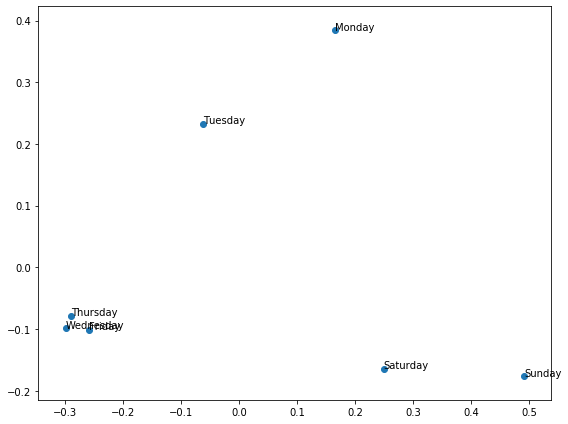

In [19]:
plot_embedding(model, encoders, 'Embedding_weekday','weekday')

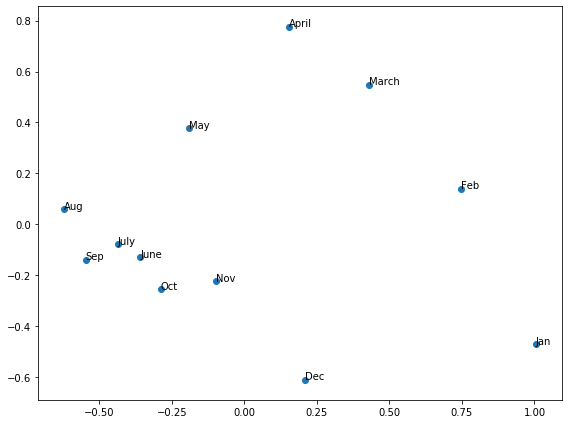

In [20]:
plot_embedding(model, encoders,'Embedding_month', 'month')

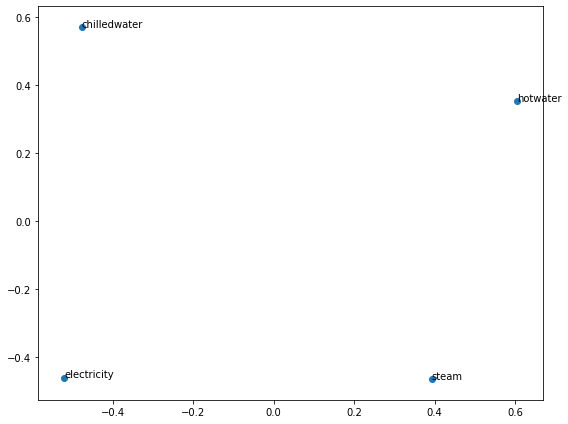

In [21]:
plot_embedding(model, encoders,'Embedding_meter', 'meter')

In [ ]:
'''
weekday: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
embedding_layer = model.get_layer('Embedding_month')
weights_Embedding_month = embedding_layer.get_weights()[0]
weights_Embedding_month
'''
#train1

In [22]:
%%time
### For Train Data
for col in cat_vars:
    weight_embed = 'Embedding_' + col
    weight_df = pd.DataFrame(model.get_layer(weight_embed).get_weights()[0]).reset_index()
    for i in weight_df.columns:
        if i != 'index':
            sub_dict = dict(zip(weight_df['index'],weight_df[i]))
            col_name_label = col
            col_name = col + '_' + str(i)
            train[col_name] = train[col_name_label].map(sub_dict).values

Wall time: 14.3 s


In [23]:
%%time
### For Test Data
for col in cat_vars:
    weight_embed = 'Embedding_' + col
    weight_df = pd.DataFrame(model.get_layer(weight_embed).get_weights()[0]).reset_index()
    for i in weight_df.columns:
        if i != 'index':
            sub_dict = dict(zip(weight_df['index'],weight_df[i]))
            col_name_label = col
            col_name = col + '_' + str(i)
            test[col_name] = test[col_name_label].map(sub_dict).values

In [24]:
print('Dropping these columns',cat_vars)
train = train.drop(columns=cat_vars, axis=1)
test = test.drop(columns=cat_vars, axis=1)

Dropping these columns ['Building_id', 'meter', 'primary_use', 'month', 'weekday']


In [ ]:
test.head()

In [29]:
(train.columns)

Index(['timestamp', 'meter_reading', 'site_id', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'DayNumber', 'air_temperature*dew_temperature',
       'log_square_feet', 'Age_of_Building', 'Building_id_0', 'Building_id_1',
       'Building_id_2', 'Building_id_3', 'Building_id_4', 'Building_id_5',
       'Building_id_6', 'Building_id_7', 'Building_id_8', 'Building_id_9',
       'Building_id_10', 'Building_id_11', 'Building_id_12', 'Building_id_13',
       'Building_id_14', 'meter_0', 'meter_1', 'primary_use_0',
       'primary_use_1', 'primary_use_2', 'primary_use_3', 'primary_use_4',
       'primary_use_5', 'primary_use_6', 'primary_use_7', 'month_0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3'],
      dtype='object')

In [30]:
(test.columns)

Index(['row_id', 'timestamp', 'site_id', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour',
       'DayNumber', 'air_temperature*dew_temperature', 'log_square_feet',
       'Age_of_Building', 'Building_id_0', 'Building_id_1', 'Building_id_2',
       'Building_id_3', 'Building_id_4', 'Building_id_5', 'Building_id_6',
       'Building_id_7', 'Building_id_8', 'Building_id_9', 'Building_id_10',
       'Building_id_11', 'Building_id_12', 'Building_id_13', 'Building_id_14',
       'meter_0', 'meter_1', 'primary_use_0', 'primary_use_1', 'primary_use_2',
       'primary_use_3', 'primary_use_4', 'primary_use_5', 'primary_use_6',
       'primary_use_7', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3'],
      dtype='object')

In [31]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

train.select_dtypes(exclude=numerics)

,timestamp,site_id,hour,log_square_feet
0,2016-01-01 00:00:00,0,0,8
1,2016-01-01 00:00:00,0,0,7
2,2016-01-01 00:00:00,0,0,8
3,2016-01-01 00:00:00,0,0,10
4,2016-01-01 00:00:00,0,0,11
...,...,...,...,...
20216095,2016-12-31 23:00:00,15,23,9
20216096,2016-12-31 23:00:00,15,23,8
20216097,2016-12-31 23:00:00,15,23,9
20216098,2016-12-31 23:00:00,15,23,10


#### Baseline Model Kfold Cross Validation

In [32]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#train["primary_use"] = le.fit_transform(train["primary_use"])

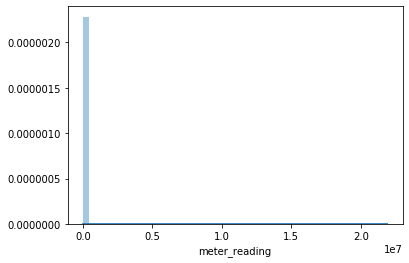

In [33]:
sns.distplot(train['meter_reading'])

In [34]:
print('Converting into log')
train["meter_reading"] = np.log1p(train["meter_reading"])

Converting into log


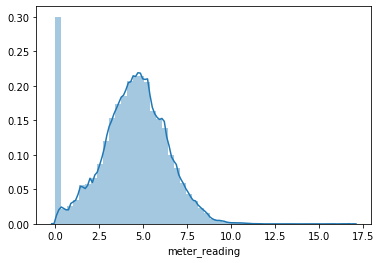

In [35]:
sns.distplot(train['meter_reading'])

In [36]:
y = train['meter_reading']
X = train.drop(['meter_reading', 'site_id','timestamp'], axis=1)
del train
gc.collect()

7703

In [37]:
print('Columns Name of Train')
columns = X.columns
columns

Columns Name of Train


Index(['floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'DayNumber', 'air_temperature*dew_temperature',
       'log_square_feet', 'Age_of_Building', 'Building_id_0', 'Building_id_1',
       'Building_id_2', 'Building_id_3', 'Building_id_4', 'Building_id_5',
       'Building_id_6', 'Building_id_7', 'Building_id_8', 'Building_id_9',
       'Building_id_10', 'Building_id_11', 'Building_id_12', 'Building_id_13',
       'Building_id_14', 'meter_0', 'meter_1', 'primary_use_0',
       'primary_use_1', 'primary_use_2', 'primary_use_3', 'primary_use_4',
       'primary_use_5', 'primary_use_6', 'primary_use_7', 'month_0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3'],
      dtype='object')

In [38]:
params = {  'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

In [39]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
columns = X.columns
splits = folds.split(X, y)
#y_preds = np.zeros(X_test.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

y_oof = np.zeros(X.shape[0])
score = 0
model_all =list()
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('*********',fold_n+1,'*********')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(params, dtrain, 500, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    model_all.append(clf)
    
    ## Geting Important Features
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | rmse: {np.sqrt(mean_squared_error(y_valid, y_pred_valid))}")
    
    score += np.sqrt(mean_squared_error(y_valid, y_pred_valid)) / NFOLDS
        
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean rmse = {score}")
print(f"Out of folds rmse = {np.sqrt(mean_squared_error(y, y_oof))}")

********* 1 *********
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.560133	valid_1's rmse: 1.31836
Early stopping, best iteration is:
[190]	training's rmse: 0.564499	valid_1's rmse: 1.31762
Fold 1 | rmse: 1.317616024637855
********* 2 *********
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.543872	valid_1's rmse: 1.10116
Early stopping, best iteration is:
[146]	training's rmse: 0.571891	valid_1's rmse: 1.09705
Fold 2 | rmse: 1.0970523016913396
********* 3 *********
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.548947	valid_1's rmse: 1.08549
Early stopping, best iteration is:
[112]	training's rmse: 0.604518	valid_1's rmse: 1.08185
Fold 3 | rmse: 1.0818462686751957
********* 4 *********
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's rmse: 0.703548	valid_1's rmse: 1.17077
Fold 4 | rmse: 1.170770010161780

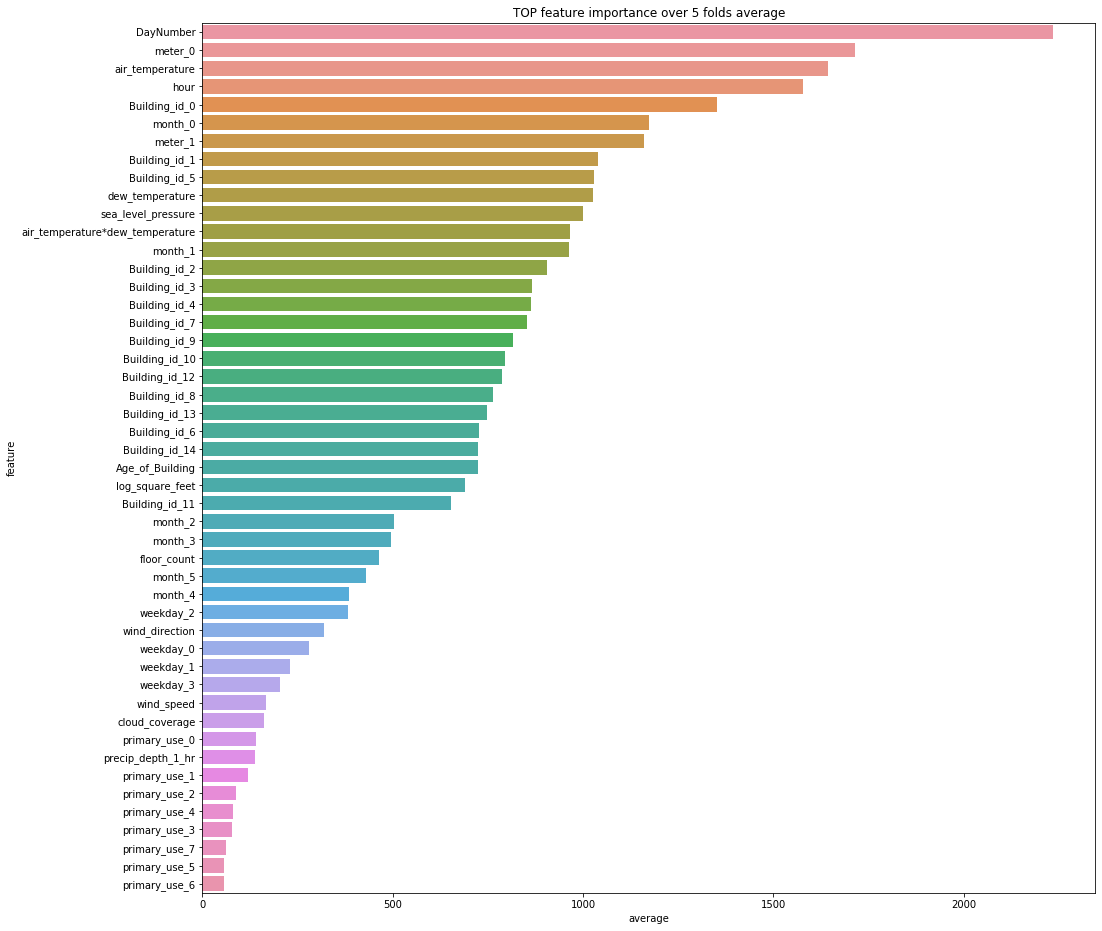

In [40]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
#feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(folds.n_splits));

#### Submission

In [ ]:
#test["primary_use"] = le.fit_transform(test["primary_use"])

In [ ]:
#%%time
#test["primary_use"] = le.fit_transform(test["primary_use"])
#test=test[columns]
#test.head()

In [43]:
columns

Index(['floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour', 'DayNumber', 'air_temperature*dew_temperature',
       'log_square_feet', 'Age_of_Building', 'Building_id_0', 'Building_id_1',
       'Building_id_2', 'Building_id_3', 'Building_id_4', 'Building_id_5',
       'Building_id_6', 'Building_id_7', 'Building_id_8', 'Building_id_9',
       'Building_id_10', 'Building_id_11', 'Building_id_12', 'Building_id_13',
       'Building_id_14', 'meter_0', 'meter_1', 'primary_use_0',
       'primary_use_1', 'primary_use_2', 'primary_use_3', 'primary_use_4',
       'primary_use_5', 'primary_use_6', 'primary_use_7', 'month_0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3'],
      dtype='object')

In [44]:
test=test[columns]
test.head()

,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,DayNumber,...,month_0,month_1,month_2,month_3,month_4,month_5,weekday_0,weekday_1,weekday_2,weekday_3
0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,1,...,-0.557739,0.211797,0.987777,-0.028873,0.574186,0.059994,-0.072055,-0.107563,0.564499,-0.033751
1,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,1,...,-0.557739,0.211797,0.987777,-0.028873,0.574186,0.059994,-0.072055,-0.107563,0.564499,-0.033751
2,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,1,...,-0.557739,0.211797,0.987777,-0.028873,0.574186,0.059994,-0.072055,-0.107563,0.564499,-0.033751
3,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,1,...,-0.557739,0.211797,0.987777,-0.028873,0.574186,0.059994,-0.072055,-0.107563,0.564499,-0.033751
4,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,0,1,...,-0.557739,0.211797,0.987777,-0.028873,0.574186,0.059994,-0.072055,-0.107563,0.564499,-0.033751


In [45]:
from tqdm import tqdm
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test.iloc[i:i+step_size]) for model in model_all])/NFOLDS))
    i+=step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [13:19<00:00,  1.04it/s]


In [46]:
res = np.concatenate(res)

In [47]:
res.shape

(41697600,)

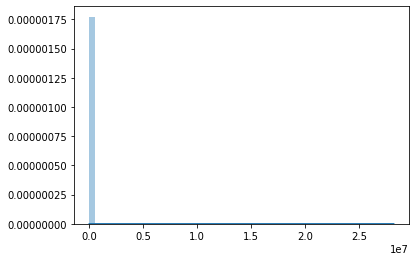

In [48]:
sns.distplot(res)

In [49]:
sub = pd.read_csv("C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/sample_submission.csv")
sub.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [52]:
%%time
sub['meter_reading'] = res
sub.loc[sub['meter_reading']<0, 'meter_reading'] = 0
sub.to_csv('submission.csv', index=False)
sub

Wall time: 2min 26s


,row_id,meter_reading
0,0,1.122790
1,1,0.949914
2,2,0.672264
3,3,1.259190
4,4,1.534207
...,...,...
41697595,41697595,6.342535
41697596,41697596,4.586544
41697597,41697597,3.367343
41697598,41697598,180.496752


In [ ]:
test.head()